# Large-Scale Image Processing On Your Laptop (and elsewhere)

### ImageXD 2018 Hackathon
#### Valentina Staneva & Dani Ushizima

---
### Goals of this demo:

* exercise the Python [Dask ndarray](https://dask-ndfilters.readthedocs.io/en/latest/dask_ndfilters.html) 
* perform image analysis on data volumes

#### Algorithm
1. Get a stack: simulated data
2. median to remove salt-pepper using dask_ndfilters.median_filter
3. k-cluster using dask_ml
4. connected components ?

The Dask library provides several useful objects
* [Dask Arrays](http://dask.pydata.org/en/latest/array.html) (for numpy-like operations) *
* [Dask DataFrames](http://dask.pydata.org/en/doc-test-build/dataframe.html) (for pandas-like operations)
* [Dask Bags](http://dask.pydata.org/en/latest/bag.html) (for unstructured-data-like operations, such as text)
* [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html) (for general functions and operations) *

In [1]:
import os
path = os.path.join('data','fiber')

In [2]:
# some preliminary imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Dask Arrays

Dask arrays are similar to numpy arrays, except that they are chunked into small pieces.

In [3]:
import dask.array as da
from dask.array.image import imread

We can read a collection of images into a dask array.

In [61]:
fiber_images = imread(os.path.join(path,'*.tif'))
fiber = fiber_images[:,::1,::1]
_,m,n = fiber.shape

Let's look at it:

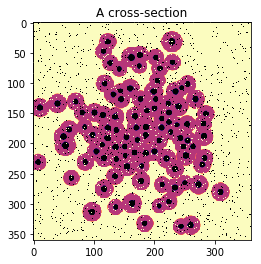

In [62]:
plt.imshow(fiber.reshape(m,n),cmap='magma')
plt.title('A cross-section')


In [63]:
import dask_ndfilters as dandf
fiber_median = dandf.median_filter(fiber, size=3, footprint=None, mode='reflect', cval=0.0, origin=0)

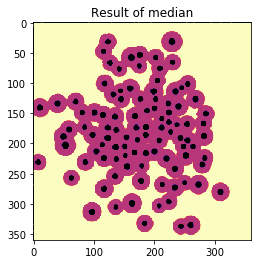

In [64]:
plt.imshow(fiber_median.reshape(m,n),cmap='magma')
plt.title('Result of median')

In [65]:
fiber_edges = dandf.sobel(fiber_median, axis=2)

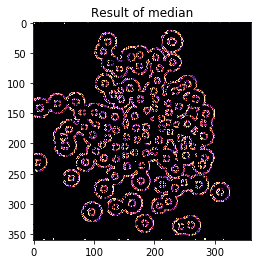

In [66]:
plt.imshow(fiber_edges.reshape(m,n),cmap='magma')
plt.title('Result of median')

## The dask_ml.cluster module implements several algorithms for clustering unlabeled data.

In [67]:
import dask_ml.cluster as damlc
myKmeans = damlc.KMeans(n_clusters=3, init='k-means||', oversampling_factor=2, max_iter=300, tol=0.0001, precompute_distances='auto', random_state=None, copy_x=True, n_jobs=1, algorithm='full', init_max_iter=None)

In [68]:
vfiber_median = fiber_median.reshape((m*n,1))#transform fiber_median into array-like, shape = [n_samples, n_features]
vfiber_median.shape

(129600, 1)

In [69]:
myKmeans.fit(vfiber_median.astype(np.float32))
fiber_segm= myKmeans.labels_.reshape(m,n)

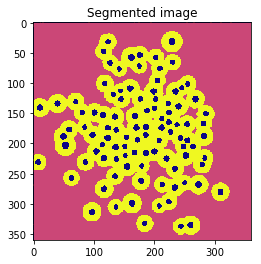

In [70]:
plt.imshow(fiber_segm,cmap='plasma')
plt.title('Segmented image')

In [ ]:
#fiber_clusters = damlc.KMeans.predict(vfiber_median,myKmeans) #careful with damlc kmeans and Kmeans
#New data to predict. Returns labels : array, shape [n_samples,] Index of the cluster each sample belongs to.